In [1]:
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import IPython.display as ipd
import numpy as np
%matplotlib notebook

# Phasor

In [2]:
# parameter setting
amp = 1     # range [0.0, 1.0]
sr = 44100       # sampling rate, Hz, must be integer
dur = 1.0   # in seconds, may be float
freq = 100.0        # sine frequency, Hz, may be float

hz : 1초에 몇번? 
sr, freq 모두 hz 유닛을 쓰지만 다른 개념
sr: 1초에 숫자가 몇번
freq: 1초에 곡선이 몇번 ?(고주파, 저주파 나타냄)

모든 sound는 sin 곡선의 합이다 

phasor=sin wave를 만들어내는 것

amplity: 범위
sr: 개별 숫자들이 1초에 몇번 있는지
freq

이 정보들로 하나의 sin wave 만들 수 있음

In [3]:
# generate time
t = np.arange(1, sr * dur)/sr 

np 안에 있는 sin 함수를 쓴다.
sin 함수는 어떤 input을 받는가?
소리를 만들기 위해서 '시간'이 필요

t=np.arange(1, sr) -> 1부터 sr까지 숫자

t=np.arange(1,sr+1)/sr -> sr이 10000이라고 할 때, 1/10000 부터 10000/10000 =1 까지. 
즉 sr은 1초에 10000개의 시간을 만든다는 의미.

t=np.arange(1, sr*0.5)/sr -> 1/10000 부터 5000/10000=0.5 까지

t=np.arange(1,sr*0.5+1)
len(t)=5000

In [4]:
# generate phase
theta = t * 2*np.pi * freq   

phase= 각도값
freq 개념이 들어가면 각도로 변환이 가능

theta=t*2*pi
->위에서 만든 t에 2pi를 곱한 것. 즉 0부터 2pi까지를 10000개로 나눈 것. 

theta=t*2*pi*2
-> frequency가 2. 0부터 4pi까지가 됨. 두번 돌게 됨 (2pi=360도. 1frequency라고 생각하면 됨)

따라서 theta=t*2*pi*freq

t와 theta의 길이는 같음. theta는 t의 시간과 정확히 sync된 각도값..
2*np.pi -> numpy 안에 있는 pi 값을 가져오는 것

In [5]:
# generate signal by cosine-phasor
s = np.sin(theta)

c=np.exp
sine 값이 아니라 exp로 받는 경우?

실수/복소수 (a+bi)
실수는 1차원에 표현 가능하지만, 복소수는 2차원에 표현함. 복소평면

앞에 만든 rate를 복소평면에 나타내면 원 모양으로 계속 회전.


Text(0,0.5,'real')

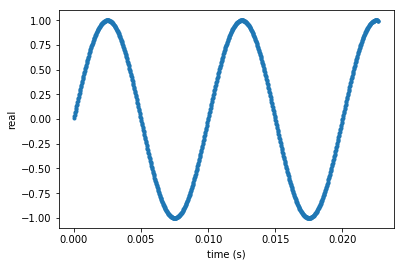

In [6]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(t[0:1000], s[0:1000], '.')
ax.set_xlabel('time (s)')
ax.set_ylabel('real')

In [7]:
# generate signal by exponential-phasor
c = np.exp(theta*1j)

Text(0.5,0,'imag')

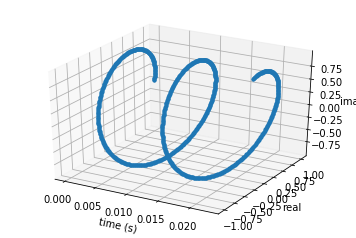

In [8]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(t[0:1000], c.real[0:1000], c.imag[0:1000], '.')
ax.set_xlabel('time (s)')
ax.set_ylabel('real')
ax.set_zlabel('imag')

plotting 하는 데에는 theta가 사용되지 않음 

In [9]:
ipd.Audio(s, rate=sr)

# Generate pulse train

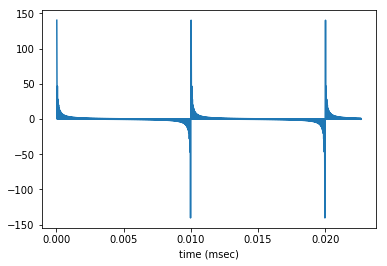

In [10]:
# generate samples, note conversion to float32 array
F0 = 100; Fend = int(sr/2); s = np.zeros(len(t));
for freq in range(F0, Fend, F0):
    theta = t * 2*np.pi * freq
    tmp = amp * np.sin(theta)
    s = s + tmp
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(t[0:1000], s[0:1000]); 
ax.set_xlabel('time (msec)')
ipd.Audio(s, rate=sr)

변수들 조정해서 소리 들어볼 수 있음

# load wav

In [24]:
from scipy.io import wavfile
sr, s = wavfile.read('a.wav')
nSamp = len(s)
dur = nSamp / sr
t = np.linspace(1/sr, dur, nSamp)

# fourier tranform

In [25]:
nFFT = 512
amp = [];
for n in range(1,nFFT+1):
    theta = 2*np.pi*n/nFFT * np.arange(1,nSamp+1)
    c = np.exp(theta*1j)
    amp.append(np.abs(np.dot(s,c)))

Text(0, 0.5, 'amplitude')

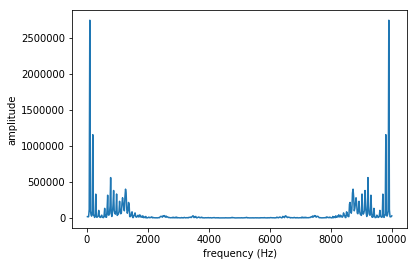

In [26]:
fig = plt.figure()
ax = fig.add_subplot(111)
freq = np.arange(1,nFFT+1)*sr/nFFT;
ax.plot(freq, amp)
ax.set_xlabel('frequency (Hz)')
ax.set_ylabel('amplitude')

# define spectrogram functions

In [ ]:
def gaussian_spectrogram(x, fs, window_dur=0.005, step_dur=None, dyn_range=120, 
                         cmap=None, ax=None):
    from scipy.signal import spectrogram, gaussian
    from matplotlib.colors import LogNorm
    from matplotlib.cm import get_cmap
    
    # set default for step_dur, if unspecified. This value is optimal for Gaussian windows.
    if step_dur is None:
        step_dur = window_dur / np.sqrt(np.pi) / 8
    
    # convert window & step durations from seconds to numbers of samples (which is what
    # scipy.signal.spectrogram takes as input).
    window_nsamp = int(window_dur * fs * 2)
    step_nsamp = int(step_dur * fs)
    
    # make the window. A Gaussian filter needs a minimum of 6σ - 1 samples, so working
    # backward from window_nsamp we can calculate σ.
    window_sigma = (window_nsamp + 1) / 6
    window = gaussian(window_nsamp, window_sigma)
    
    # convert step size into number of overlapping samples in adjacent analysis frames
    noverlap = window_nsamp - step_nsamp
    
    # compute the power spectral density
    freqs, times, power = spectrogram(x, detrend=False, mode='psd', fs=fs,
                                      scaling='density', noverlap=noverlap,
                                      window=window, nperseg=window_nsamp)

    p_ref = 2e-5  # 20 μPa, the standard reference pressure for sound in air

    # set lower bound of colormap (vmin) from dynamic range. The upper bound defaults
    # to the largest value in the spectrogram, so we don't need to set it explicitly.
    dB_max = 10 * np.log10(power.max() / (p_ref ** 2))
    vmin = p_ref * 10 ** ((dB_max - dyn_range) / 10)

    # set default colormap, if none specified
    if cmap is None:
        cmap = get_cmap('Greys')
    # or if cmap is a string, get the actual object
    elif isinstance(cmap, str):
        cmap = get_cmap(cmap)

    # create the figure if needed
    if ax is None:
        fig, ax = plt.subplots()

    # other arguments to the figure
    extent = (times.min(), times.max(), freqs.min(), freqs.max())

    # plot
    ax.imshow(power, origin='lower', aspect='auto', cmap=cmap,
              norm=LogNorm(), extent=extent, vmin=vmin, vmax=None)
    return ax

def praat_spectrogram(x, fs, window_dur=0.005, dyn_range=120, ax=None):
    # this function is less flexible than the other (to make it shorter, 
    # since it's just for demo purposes).
    from scipy.signal import spectrogram, gaussian
    from matplotlib.cm import get_cmap
    
    step_dur = window_dur / np.sqrt(np.pi) / 8.
    window_nsamp = int(window_dur * fs * 2)
    step_nsamp = int(step_dur * fs)
    window_sigma = (window_nsamp + 1) / 6
    window = gaussian(window_nsamp, window_sigma)
    noverlap = window_nsamp - step_nsamp
    freqs, times, power = spectrogram(x, detrend=False, mode='psd', fs=fs,
                                      scaling='density', noverlap=noverlap,
                                      window=window, nperseg=window_nsamp)
    p_ref = 2e-5
    log_psd = 10 * np.log10(power / (p_ref ** 2))  # key difference
    dB_max = log_psd.max()
    vmin = p_ref * 10 ** ((dB_max - dyn_range) / 10)
    cmap = get_cmap('Greys')
    if ax is None:
        fig, ax = plt.subplots()
    extent = (times.min(), times.max(), freqs.min(), freqs.max())
    # next line: pass `log_psd` instead of `power`; no `LogNorm`
    ax.imshow(log_psd, origin='lower', aspect='auto', cmap=cmap,
              extent=extent, vmin=vmin, vmax=None)
    return ax

# display spectrogram

Text(0.5, 1.0, 'Log power spectral density & linear colormap')

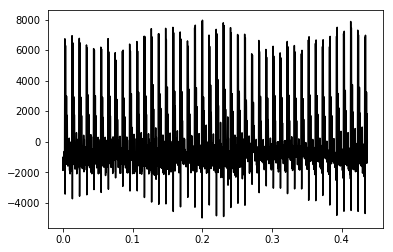

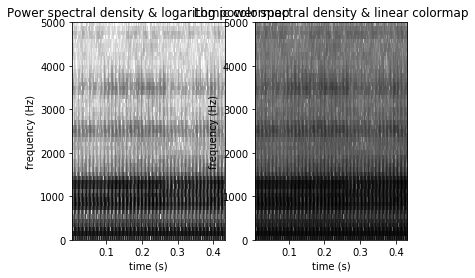

In [6]:
plt.plot(t,s, 'k')

fig, axs = plt.subplots(1, 2)
ax = gaussian_spectrogram(s, sr, ax=axs[0])
ax.set_ylim(0, sr/2)
ax.set_xlabel('time (s)')
ax.set_ylabel('frequency (Hz)')
ax.set_title('Power spectral density & logarithmic colormap')

ax = praat_spectrogram(s, sr, ax=axs[1])
ax.set_ylim(0, sr/2)
ax.set_xlabel('time (s)')
ax.set_ylabel('frequency (Hz)')
ax.set_title('Log power spectral density & linear colormap')